### 암 재발 가능성

로지스틱은 S자 함수를 하용하여 참과 거짓을 분류한다.'\

로지스틱 회귀에서 사용하는 S자 함수가 시그모이드 함수다. 시드모이드 함수는 x의 값이 커지면 y의 값은 1에 근사하게 되고 x의 값이 작아지면 y의 값은 0에 근사하게 되어 S자 형태의 그래프가 도된다.

로지스틱 회귀 모델은 오차행렬에 기반한 성능지표인 정밀고, 재현율, f1 스코어, ROC_AUC를 사용한다. 

In [78]:
import sys
sys.path.append('../../')
import helper

import numpy as np
from pandas import read_excel, DataFrame, get_dummies, merge
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 로지스틱 회귀 분석의 피처로 사용할 데이터를 평균이 0 분산이 1이 되는 정규 분포 형태로 맞춘다. 
from sklearn.preprocessing import StandardScaler


In [54]:
origin = read_excel("https://data.hossam.kr/F03/biostat.xlsx", index_col='id')
origin.head()

,age,sex,weight,OP_date,Recur,Recur_1y,Recur_date,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,,,,
1,82,1,73.994588,2014-07-10,1,0,2015-08-12,144.286869,4490.5,0.1,3.0,5.1,3,1,1,36.795194,0,1
2,50,0,64.819694,2013-05-08,0,0,2018-07-07,108.590964,36.7,0.1,1.1,1.5,3,1,0,32.765043,0,1
3,28,1,63.204675,2016-05-06,0,0,2020-01-13,5.629379,36.7,0.1,10.7,12.4,3,1,0,31.133072,0,1
4,35,1,52.499192,2015-11-24,1,0,2017-08-07,143.931300,64.9,1.3,1.3,0.4,3,1,1,36.134051,0,1
5,49,1,72.766264,2015-02-12,1,0,2016-06-02,172.653143,38.2,10.7,3.7,0.4,3,1,0,33.921657,0,1


|필드명	|설명|	비고|
|--|--|--|
id	|고유번호	
age	|나이	
sex|	성별|	0=여성, 1=남성
weight	|체중	
OP_date	|수술 날짜	
Recur|	재발 여부|	1=재발, 0=마지막 관찰시점까지 재발 안함
Recur_1y	|1년 내 재발 여부 |	1=1년 내 재발, 0=1년 내 재발 안함
Recur_date	|재발 날짜|	재발하지 않은 환자의 경우 마지막 검사 날짜
SBP	|수축기 혈압	
CA19.9	|종양표지자의 일종인 CA19-9값	
CRP	|C-반응 단백질 수치	
CEA	|종용표지자의 일종인 CEA 값	
post.CEA|	수술 직후 CEA 값	
stage	|암의 병기	|1, 2, 3
smoking	|흡연 여부	|1=흡연, 0=비흡연
obesity|	비만 여부	|1=비만, 0=정상
post.CA19.9	수술 직후| CA19-9값	
post.CA19.9.binary	|post.CA19.9가 37 초과이면 1, 37 이하이면 0	
post.CA19.9.3grp	|post.CA19.9가 37 이하이면 1, 37초과 100 이히면 2, 70 초과이면 3	


In [55]:
# 진단 데이터 크기
origin.shape

(156, 18)

In [56]:
# 결측치 확인
origin.isna().sum()

age                   0
sex                   0
weight                0
OP_date               0
Recur                 0
Recur_1y              0
Recur_date            0
SBP                   0
CA19.9                0
CRP                   0
CEA                   0
post.CEA              0
stage                 0
smoking               0
obesity               0
post.CA19.9           0
post.CA19.9.binary    0
post.CA19.9.3grp      0
dtype: int64

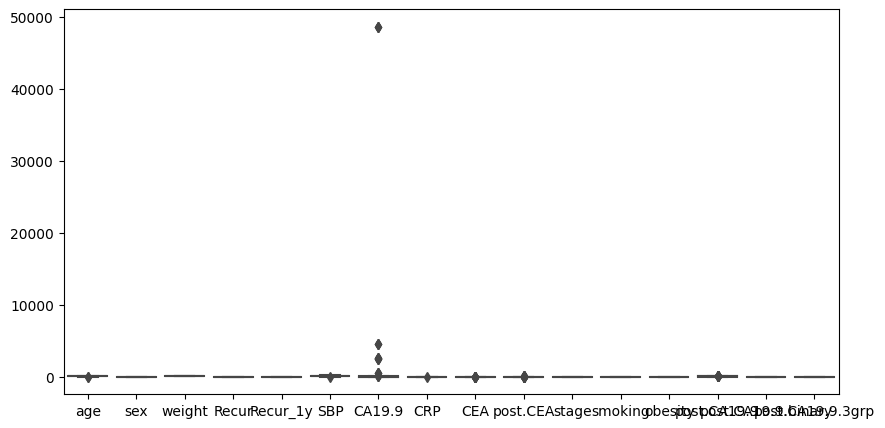

In [57]:
# 상자 그림으로 이상치 확인
plt.figure(figsize=(10, 5))
sb.boxplot(data=origin)
plt.show()
plt.close()


In [58]:
# 인덱스로 id를 설정

In [59]:
# 불필요한 변수 삭제
origin = origin.drop(['OP_date','Recur_date','Recur_1y'],axis=1)
origin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 1 to 156
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 156 non-null    int64  
 1   sex                 156 non-null    int64  
 2   weight              156 non-null    float64
 3   Recur               156 non-null    int64  
 4   SBP                 156 non-null    float64
 5   CA19.9              156 non-null    float64
 6   CRP                 156 non-null    float64
 7   CEA                 156 non-null    float64
 8   post.CEA            156 non-null    float64
 9   stage               156 non-null    int64  
 10  smoking             156 non-null    int64  
 11  obesity             156 non-null    int64  
 12  post.CA19.9         156 non-null    float64
 13  post.CA19.9.binary  156 non-null    int64  
 14  post.CA19.9.3grp    156 non-null    int64  
dtypes: float64(7), int64(8)
memory usage: 19.5 KB


## 탐색적데이터 분석

In [60]:
# 명목형에 대한 데이터 타입 설정
origin['sex'] = origin['sex'].astype('category')
origin['Recur'] = origin['Recur'].astype('category')
origin['stage'] = origin['stage'].astype('category')
origin['smoking'] = origin['smoking'].astype('category')
origin['obesity'] = origin['obesity'].astype('category')
origin['post.CA19.9.binary'] = origin['post.CA19.9.binary'].astype('category')
origin['post.CA19.9.3grp'] = origin['post.CA19.9.3grp'].astype('category')

origin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 1 to 156
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   age                 156 non-null    int64   
 1   sex                 156 non-null    category
 2   weight              156 non-null    float64 
 3   Recur               156 non-null    category
 4   SBP                 156 non-null    float64 
 5   CA19.9              156 non-null    float64 
 6   CRP                 156 non-null    float64 
 7   CEA                 156 non-null    float64 
 8   post.CEA            156 non-null    float64 
 9   stage               156 non-null    category
 10  smoking             156 non-null    category
 11  obesity             156 non-null    category
 12  post.CA19.9         156 non-null    float64 
 13  post.CA19.9.binary  156 non-null    category
 14  post.CA19.9.3grp    156 non-null    category
dtypes: category(7), float64(7), int64(1)
memory u

In [61]:
# 기술 통계량 확인
origin.describe()

,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,56.858974,68.125624,115.898871,1158.631410,3.062821,3.930128,5.363462,48.193259
std,12.790343,14.467480,37.701583,6709.440806,3.550361,4.135752,12.846207,22.921452
min,25.000000,40.000000,5.629379,1.000000,0.100000,0.300000,0.100000,30.760115
25%,50.000000,58.257205,89.074804,10.400000,0.100000,1.500000,0.600000,34.908674
50%,58.000000,69.084391,114.647853,23.150000,1.300000,2.400000,1.650000,41.285774
75%,65.000000,80.053547,144.331917,61.725000,4.850000,4.525000,4.800000,51.216016
max,82.000000,95.000000,206.847716,48599.800000,12.300000,20.400000,118.500000,174.433426


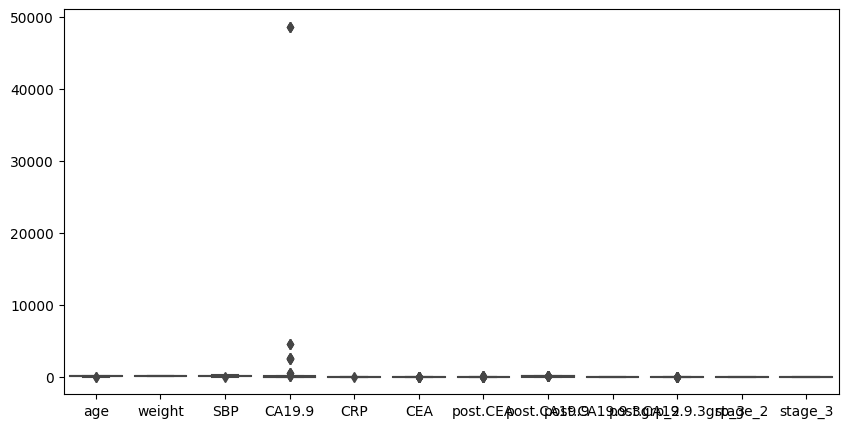

In [62]:
# 상자 그림으로 이상치 확인
plt.figure(figsize=(10, 5))
sb.boxplot(data=origin_df)
plt.show()
plt.close()

In [63]:
#origin = origin.rename(columns={'CA19.9':'CA19_9'})# CA19.9 이름 변경   
origin.query("`CA19.9` > 40000") 


,age,sex,weight,Recur,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,
11,64,1,87.019677,1,93.901218,48599.6,9.4,1.4,3.9,2,1,1,34.956666,0,1
63,60,1,80.024716,1,192.226734,48599.8,9.7,4.7,9.5,2,0,1,41.421145,1,2
115,61,1,74.031541,1,176.594650,48599.3,10.4,6.6,6.6,2,0,1,36.516956,0,1


In [64]:
origin.query("stage == 2")

# 다른 췌장암 2기와 비교했을 경우 큰 차이가 나므로 `CA19.9` 수치가 4만을 넘는 경우를 이상치로 판단하고 제거하기로 함

,age,sex,weight,Recur,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,
9,69,0,53.920287,1,108.237287,19.9,0.1,4.6,15.1,2,1,0,62.095475,1,2
10,39,1,64.035273,0,88.061020,84.2,9.6,4.3,6.1,2,1,0,50.118498,1,2
11,64,1,87.019677,1,93.901218,48599.6,9.4,1.4,3.9,2,1,1,34.956666,0,1
12,69,1,70.208801,1,163.587691,49.5,0.1,7.2,8.2,2,1,1,34.626853,0,1
23,64,1,82.150157,0,169.410154,67.3,3.5,1.8,0.9,2,1,0,34.890297,0,1
26,59,0,60.346471,0,121.918068,12.7,1.7,1.2,0.2,2,1,0,44.344380,1,2
27,41,0,53.729653,0,95.660858,7.6,0.1,8.3,19.4,2,1,1,34.043468,0,1
29,48,1,70.060164,0,108.765715,15.0,3.8,6.8,3.6,2,0,0,44.855612,1,2
30,34,1,71.468074,0,51.737041,49.6,3.9,4.2,1.5,2,0,0,43.407932,1,2


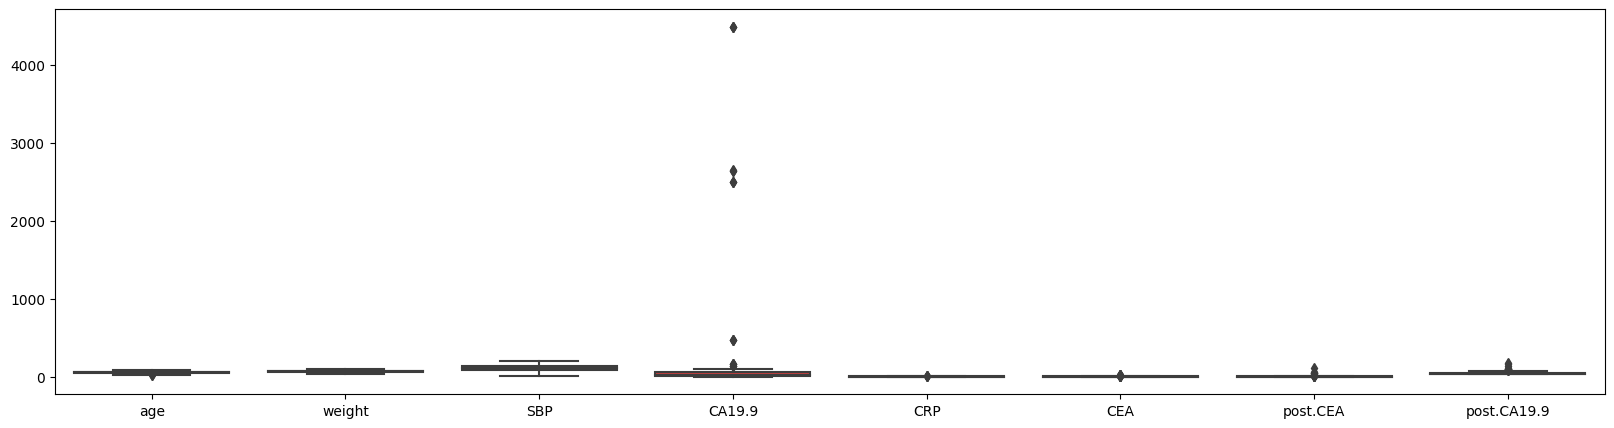

In [65]:
# CA19.9 이상치 삭제
origin_df = origin.drop(origin.query("`CA19.9` > 40000").index)

# 박스로 다시 확인 
plt.figure(figsize=(20, 5))
sb.boxplot(data=origin_df)
plt.show()
plt.close()

# # CA19.9 이상치 삭제 이건 내가 했던 방식 
# # max_value = max(origin["CA19_9"])
# origin_df = origin.sort_values("'CA19.9'",inplace=True) 
# origin_df = origin[:-3]
# origin_df

In [66]:
x = origin_df.drop(['Recur'],axis = 1)
y = origin_df['Recur']
x.shape, y.shape

((153, 14), (153,))

### 데이터 표준화

#### 명목형 변수는 더미변수로 변환해야 하므로 데이터를 종류별로 구분

##### 연속형 변수만 추출

In [67]:
x1 = x.drop(['sex', 'stage', 'smoking', 'obesity', 'post.CA19.9.binary', 'post.CA19.9.3grp'], axis=1)
x1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1 to 156
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          153 non-null    int64  
 1   weight       153 non-null    float64
 2   SBP          153 non-null    float64
 3   CA19.9       153 non-null    float64
 4   CRP          153 non-null    float64
 5   CEA          153 non-null    float64
 6   post.CEA     153 non-null    float64
 7   post.CA19.9  153 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 10.8 KB


#### 명목형 변수만 추출

In [68]:
x2 = x.filter(['sex', 'stage', 'smoking', 'obesity', 'post.CA19.9.binary', 'post.CA19.9.3grp'])
x2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1 to 156
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   sex                 153 non-null    category
 1   stage               153 non-null    category
 2   smoking             153 non-null    category
 3   obesity             153 non-null    category
 4   post.CA19.9.binary  153 non-null    category
 5   post.CA19.9.3grp    153 non-null    category
dtypes: category(6)
memory usage: 2.8 KB


#### 연속형 변수에 대한 표준화

In [80]:
scaler = StandardScaler()
x_scale = scaler.fit_transform(x1)
x_scale_df = DataFrame(x_scale, index=x1.index, columns=x1.columns)
x_scale_df.head()

# 이건 내가 한 코딩 
# scaler = StandardScaler
# x_scaller = StandardScaler()
# x_scale = x_scaller.fit_transform(x)
# x_scale


,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9
id,,,,,,,,
1,1.963300,0.423063,0.786098,5.459243,-0.822126,-0.222609,-0.018407,-0.504152
2,-0.526293,-0.212338,-0.176862,-0.245568,-0.822126,-0.680266,-0.296946,-0.679230
3,-2.237888,-0.324186,-2.954433,-0.245568,-0.822126,1.632102,0.546406,-0.750126
4,-1.693289,-1.065587,0.776506,-0.209447,-0.473529,-0.632091,-0.382054,-0.532873
5,-0.604092,0.337996,1.551328,-0.243646,2.257144,-0.053999,-0.382054,-0.628984


#### 명목형 변수를 더미변수로 변환

##### 데이터의 종류가 몇가지인지 확인

데이터 엑셀파일에서 `stage`, `post.CA19.9.3grp` 필드만 값이 3종류로 확인됨

In [81]:
x2_dm = get_dummies(x2, columns=['stage', 'post.CA19.9.3grp'], drop_first=True, dtype='int')
x2_dm.head()

# 내가 한 코딩
# origin_df = get_dummies(origin, columns=['post.CA19.9.3grp','stage'], drop_first=True, dtype='int')
# origin_df.head()
# boolean값으로 떨어지기 때문에 int로 변경, 첫번째 행으 ㄴ날려도 되니까 드롭-퍼스트
# 이걸 원래 데이터와 합쳐야 함

# xdf = merge(x)

,sex,smoking,obesity,post.CA19.9.binary,stage_2,stage_3,post.CA19.9.3grp_2,post.CA19.9.3grp_3
id,,,,,,,,
1,1,1,1,0,0,1,0,0
2,0,1,0,0,0,1,0,0
3,1,1,0,0,0,1,0,0
4,1,1,1,0,0,1,0,0
5,1,1,0,0,0,1,0,0


In [82]:
### 연속형과 더미변수로 변환된 명목형을 결합

xdf = merge(x_scale_df, x2_dm, left_index=True, right_index=True)
print(xdf.shape)
xdf.head()

(153, 16)


,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9,sex,smoking,obesity,post.CA19.9.binary,stage_2,stage_3,post.CA19.9.3grp_2,post.CA19.9.3grp_3
id,,,,,,,,,,,,,,,,
1,1.963300,0.423063,0.786098,5.459243,-0.822126,-0.222609,-0.018407,-0.504152,1,1,1,0,0,1,0,0
2,-0.526293,-0.212338,-0.176862,-0.245568,-0.822126,-0.680266,-0.296946,-0.679230,0,1,0,0,0,1,0,0
3,-2.237888,-0.324186,-2.954433,-0.245568,-0.822126,1.632102,0.546406,-0.750126,1,1,0,0,0,1,0,0
4,-1.693289,-1.065587,0.776506,-0.209447,-0.473529,-0.632091,-0.382054,-0.532873,1,1,1,0,0,1,0,0
5,-0.604092,0.337996,1.551328,-0.243646,2.257144,-0.053999,-0.382054,-0.628984,1,1,0,0,0,1,0,0


### 훈련 데이터와 검증 데이터로 분할

In [83]:

# 로지스틱 회귀를 이용하여 분석 모델 구축하기 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# 평가 지수 계산을 제공하는 모듈 임포트
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score 



In [84]:
x_train, x_test, y_train, y_test = train_test_split(xdf, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((107, 16), (46, 16), (107,), (46,))

## 모델개발

In [85]:

# 로지스틱 회귀 분석 : 모델 객체 생성
lr_b_cancer = LogisticRegression() 

# 로지스틱 회귀 분석 : 모델 훈련 학습 데이터로 모델 학습을 수행(fit)한다.
lr_b_cancer.fit(x_train, y_train)

# 로지스틱 회귀 분석 평가 데이터에 대한 예측 수행. x_test를 가지고 예측을 수행predict 수행하여 예측값 y_predict를 구한다)
y_predict = lr_b_cancer.predict(x_test)
# 생성한 모델의 성능 확인하기

# 오차 행렬
# 평가를 위해 7:3으로 분할한 test데이터에 대해 이진 분류의 성능 평가 기본이 되는 오차 행렬을 구한다. 
confusion_matrix(y_test,y_predict)

# 성능 평가 지표인 정확도, 정밀도, 재현율, F1스코어, ROC-AUC 스코어를 구한다.
accuracy = accuracy_score(y_test,y_predict)
precision = precision_score(y_test,y_predict)
recall = recall_score(y_test,y_predict)
f1 = f1_score(y_test,y_predict)
roc_auc = roc_auc_score(y_test,y_predict)
print('정확도:{},정밀도:{},재현율:{},F1:{}'.format(accuracy,precision,recall,f1))

print('ROC_AUC:',roc_auc)


정확도:0.8260869565217391,정밀도:0.782608695652174,재현율:0.8571428571428571,F1:0.8181818181818182
ROC_AUC: 0.8285714285714286


In [86]:
# 모델정의
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(16, )))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [87]:
# 학습하기 
result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
4/4 [==============================] - 1s 50ms/step - loss: 0.6192 - acc: 0.6355 - val_loss: 0.7238 - val_acc: 0.4130 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 9ms/step - loss: 0.5986 - acc: 0.6542 - val_loss: 0.7135 - val_acc: 0.4130 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 9ms/step - loss: 0.5840 - acc: 0.6822 - val_loss: 0.7049 - val_acc: 0.4130 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 9ms/step - loss: 0.5731 - acc: 0.6822 - val_loss: 0.6980 - val_acc: 0.4348 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 0.5621 - acc: 0.7009 - val_loss: 0.6924 - val_acc: 0.4348 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 10ms/step - loss: 0.5528 - acc: 0.7103 - val_loss: 0.6875 - val_acc: 0.4565 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 10ms/step - loss: 0.5448 - acc: 0.7103 - val_loss: 0.6814 - val_acc: 0.4783 - lr: 0.0010
Epo

## #07. 학습 결과 평가


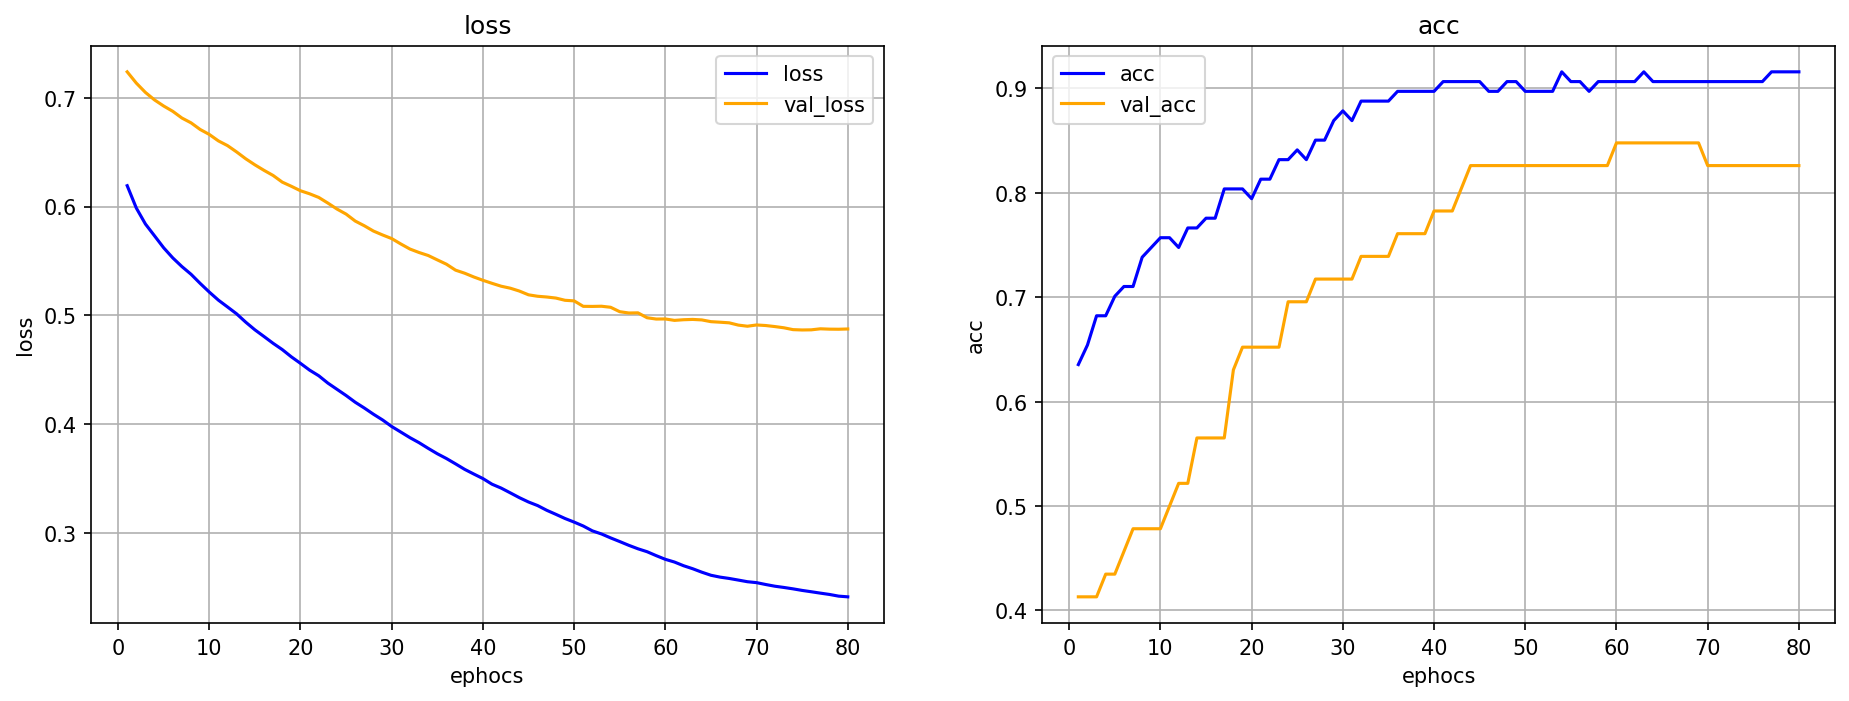

4/4 [==============================] - 0s 2ms/step - loss: 0.2405 - acc: 0.9159
최종 훈련 손실률: 0.240487, 최종 훈련 정확도: 0.915888
2/2 [==============================] - 0s 3ms/step - loss: 0.4875 - acc: 0.8261
최종 검증 손실률: 0.487499, 최종 검증 정확도: 0.826087


In [88]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

In [89]:
### 혼동행렬
logit_result = helper.tf_logit_result(model, result, x_train, y_train)
logit_result.cmdf

AttributeError: module 'helper' has no attribute 'tf_logit_result'

### 학습결과적용

In [90]:
train_pred = model.predict(x_train)
train_pred

4/4 [==============================] - 0s 829us/step


array([[0.9792073 ],
       [0.13293114],
       [0.11857773],
       [0.05192947],
       [0.17553052],
       [0.17448139],
       [0.9748557 ],
       [0.3034593 ],
       [0.90048265],
       [0.26715317],
       [0.20094247],
       [0.73592126],
       [0.2540314 ],
       [0.949854  ],
       [0.13288979],
       [0.28248176],
       [0.9435901 ],
       [0.78016615],
       [0.9700371 ],
       [0.32540557],
       [0.99867916],
       [0.7809983 ],
       [0.99606127],
       [0.958909  ],
       [0.1751375 ],
       [0.12025169],
       [0.15036981],
       [0.8627732 ],
       [0.95936674],
       [0.31501845],
       [0.21307485],
       [0.49426457],
       [0.1619699 ],
       [0.13281162],
       [0.45374534],
       [0.99687314],
       [0.6659419 ],
       [0.9934251 ],
       [0.9061632 ],
       [0.90865576],
       [0.3257125 ],
       [0.9692006 ],
       [0.97558415],
       [0.9560164 ],
       [0.1824848 ],
       [0.31841922],
       [0.28437686],
       [0.976

In [91]:
test_pred = model.predict(x_test)
test_pred

2/2 [==============================] - 0s 2ms/step


array([[0.21429826],
       [0.9100303 ],
       [0.08944497],
       [0.43235686],
       [0.84154975],
       [0.14077966],
       [0.16278593],
       [0.8298585 ],
       [0.93351936],
       [0.2099695 ],
       [0.9305167 ],
       [0.9142945 ],
       [0.46318853],
       [0.15312308],
       [0.25616047],
       [0.18272883],
       [0.62550724],
       [0.31805828],
       [0.17963804],
       [0.23484044],
       [0.11057414],
       [0.19282924],
       [0.52808064],
       [0.6793817 ],
       [0.8900841 ],
       [0.20007227],
       [0.21891212],
       [0.9402908 ],
       [0.66524625],
       [0.9957858 ],
       [0.89837563],
       [0.6666976 ],
       [0.99628955],
       [0.99987555],
       [0.7481667 ],
       [0.6156364 ],
       [0.14241846],
       [0.19712728],
       [0.8090263 ],
       [0.9507904 ],
       [0.22858915],
       [0.15102354],
       [0.16378321],
       [0.2798674 ],
       [0.9532147 ],
       [0.65603775]], dtype=float32)

In [92]:
# 결과 데이터셋 구성
train_pred_bin = (train_pred.flatten() >0.5).astype(int)
train_pred_bin

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1])

In [93]:
train_result_df = DataFrame({'y_train': y_train, 'train_pred': train_pred_bin})
train_result_df

,y_train,train_pred
id,,
126,1,1
155,0,0
133,0,0
134,0,0
103,0,0
...,...,...
74,1,1
90,0,0
61,1,0


In [94]:
train_result_df['result'] = train_result_df['y_train'] == train_result_df['train_pred']
train_result_df

,y_train,train_pred,result
id,,,
126,1,1,True
155,0,0,True
133,0,0,True
134,0,0,True
103,0,0,True
...,...,...,...
74,1,1,True
90,0,0,True
61,1,0,False


In [95]:
train_value_counts = train_result_df['result'].value_counts()
print(train_value_counts)

test_pred_bin = (test_pred.flatten() > 0.5).astype(int)


test_result_df = DataFrame({'y_test': y_test, 'test_pred': test_pred_bin})
test_result_df['result'] = test_result_df['y_test'] == test_result_df['test_pred']
test_value_counts = test_result_df['result'].value_counts()
print(test_value_counts)

result_df = DataFrame({
    'Train': [train_value_counts[True], train_value_counts[False]],
    'Test': [test_value_counts[True], test_value_counts[False]]
}, index=['Success', 'Fail'])

result_df

result
True     98
False     9
Name: count, dtype: int64
result
True     38
False     8
Name: count, dtype: int64


,Train,Test
Success,98,38
Fail,9,8


### 실제 결과값과 머신러닝에 의한 예측값 비교

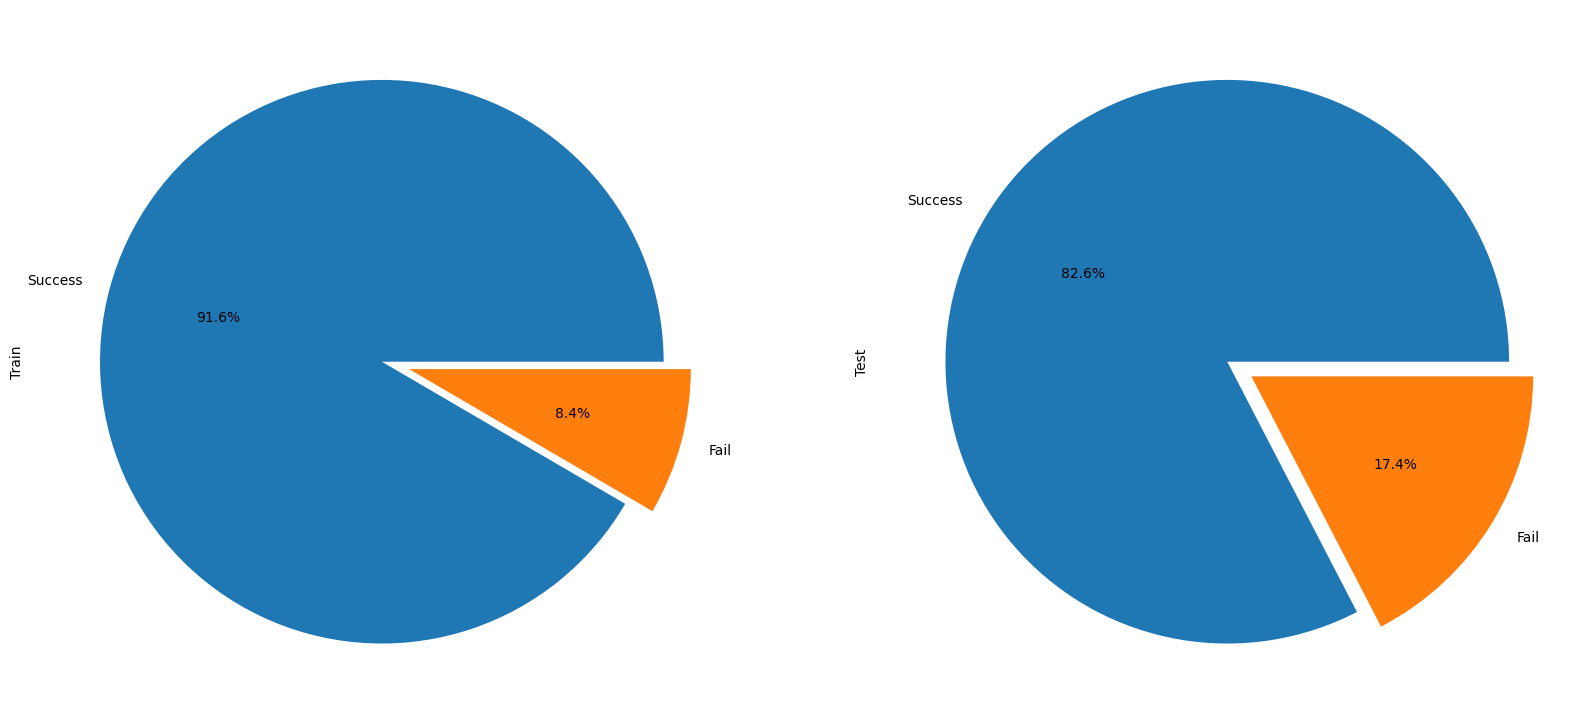

In [96]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

result_df['Train'].plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax1)
result_df['Test'].plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax2)

plt.show()
plt.close()